<a href="https://colab.research.google.com/github/IvanRobotics/AIArenaWork/blob/main/AIArena_Session2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt 
from sklearn.utils import resample
import seaborn as sns
import pandas as pd
import numpy as np
import json
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data.dataset import random_split
from sklearn.model_selection import StratifiedKFold





In [ ]:
# load the JSON file
file_path = '/content/drive/MyDrive/AI_Projects/AI Arena/training-data--session-2.json'
with open(file_path) as file:
  json_data_session2 = json.load(file)

# Extract All Features, Directions and actions
features = []
direction_action = []
other_action = []

for entry in json_data_session2:
  state = entry['state'][0]
  features.append(state[:116])
  direction_action.append(entry['action']['direction'][0])
  other_action.append(entry['action']['other'][0])


# convert to numpy array
features = np.array(features)
direction_action = np.array(direction_action)
other_action = np.array(other_action)





In [ ]:
entry_data =  {
    'features.shape ': features.shape,
    'direction_action': direction_action.shape,
    'other_action': other_action.shape
}

row_labels = ['total entry count','total elements in an entry']

entry_df = pd.DataFrame(entry_data, index = row_labels)
entry_df

,features.shape,direction_action,other_action
total entry count,23,23,23
total elements in an entry,115,9,6


In [ ]:
# check the number of unique values in each feature
Raycast_Platform_Distance = features[:,:16]
Raycast_Platform_Type = features[:,16:32]
Raycast_Projectile_Distance = features[:,32:48]
Raycast_Projectile_OnTarget =features[:,48:64]
Raycast_Projectile_Element = features[:,64:80]
Action_Representation =features[:,80:98] 
Your_Positioning = features[:,98:100]
Opponent_Positioning = features[:,100:102]
Direction = features[:,102:104]
Distance_To_Opponent = features[:,104:105]
Angle_To_Opponent= features[:,105:107]
Stocks = features[:,107:109]
Percentage = features[:,109:111]
Elemental_Gauge = features[:,111:113]
Elemental_Advantage = features[:,113:114]
Weight_Difference = features[:,114:115]
  



In [ ]:
features_list = [Raycast_Platform_Distance, Raycast_Platform_Type, Raycast_Projectile_Distance,
                 Raycast_Projectile_OnTarget, Raycast_Projectile_Element, Action_Representation,
                 Your_Positioning, Opponent_Positioning, Direction, Distance_To_Opponent,
                 Angle_To_Opponent, Stocks, Percentage, Elemental_Gauge, Elemental_Advantage,
                 Weight_Difference]


nan_feature_list = []
for feature in features_list:
  if np.isnan(feature).any():
      nan_feature_list.append(feature)

if len(nan_feature_list) == 0:
  print('There is no NAN in session 2 dataset')
else:
  print(nan_feature_list)

There is no NAN in session 2 dataset


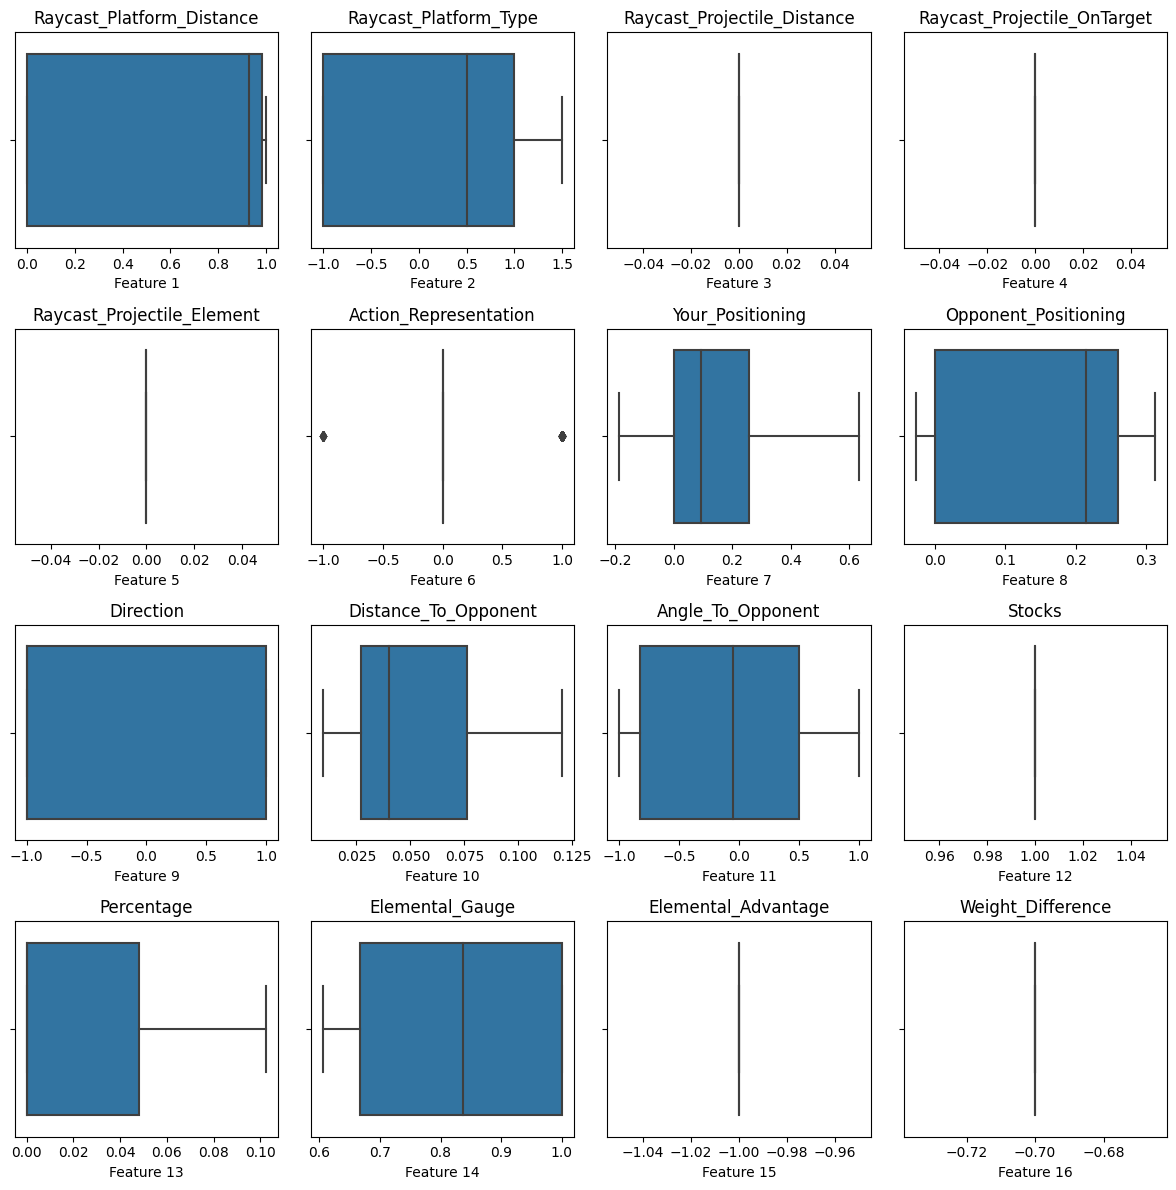

In [ ]:
features_list = [Raycast_Platform_Distance, Raycast_Platform_Type, Raycast_Projectile_Distance,
                 Raycast_Projectile_OnTarget, Raycast_Projectile_Element, Action_Representation,
                 Your_Positioning, Opponent_Positioning, Direction, Distance_To_Opponent,
                 Angle_To_Opponent, Stocks, Percentage, Elemental_Gauge, Elemental_Advantage,
                 Weight_Difference]

feature_names = ['Raycast_Platform_Distance', 'Raycast_Platform_Type', 'Raycast_Projectile_Distance',
                 'Raycast_Projectile_OnTarget', 'Raycast_Projectile_Element', 'Action_Representation',
                 'Your_Positioning', 'Opponent_Positioning', 'Direction', 'Distance_To_Opponent',
                 'Angle_To_Opponent', 'Stocks', 'Percentage', 'Elemental_Gauge', 'Elemental_Advantage',
                 'Weight_Difference']

# Preset the number of rows required
num_cols = 4
# Calculate the number of cols required
num_rows = math.ceil(len(features_list) / num_cols)

# Create subplots for each feature
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot box plots for each feature
for i, (feature, feature_name) in enumerate(zip(features_list,feature_names)):
    sns.boxplot(x=feature, ax=axes[i])
    axes[i].set_xlabel(f'Feature {i+1}')
    axes[i].set_ylabel('')
    axes[i].set_title(feature_name)

# Remove empty subplots if the number of features is not a multiple of 4
if len(features_list) % num_cols != 0:
    for j in range(len(features_list) % num_cols, num_cols):
        fig.delaxes(axes[-j-1])

plt.tight_layout()
plt.show()

From the boxplots above, I found no outliners in any feature. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier



feature_names = [
    "Raycast_Platform_Distance",
    "Raycast_Platform_Type",
    "Raycast_Projectile_Distance",
    "Raycast_Projectile_OnTarget",
    "Raycast_Projectile_Element",
    "Action_Representation",
    "Your_Positioning",
    "Opponent_Positioning",
    "Direction",
    "Distance_To_Opponent",
    "Angle_To_Opponent",
    "Stocks",
    "Percentage",
    "Elemental_Gauge",
    "Elemental_Advantage",
    "Weight_Difference"
]

all_features = np.concatenate((
    Raycast_Platform_Distance,
    Raycast_Platform_Type,
    Raycast_Projectile_Distance,
    Raycast_Projectile_OnTarget,
    Raycast_Projectile_Element,
    Action_Representation,
    Your_Positioning,
    Opponent_Positioning,
    Direction,
    Distance_To_Opponent,
    Angle_To_Opponent,
    Stocks,
    Percentage,
    Elemental_Gauge,
    Elemental_Advantage,
    Weight_Difference
    
), axis = 1)


y_train_direction =direction_action
y_train_action = other_action

clf_direction = RandomForestClassifier(n_estimators=100, random_state=42)
clf_direction.fit(all_features, y_train_direction)

clf_action = RandomForestClassifier(n_estimators=100, random_state=42)
clf_action.fit(all_features, y_train_action)

# Get the feature importances
importances_direction = clf_direction.feature_importances_
importances_action = clf_action.feature_importances_

# Print feature importance
importance_tuples = list(zip(feature_names, importances_direction))
sorted_importances_direction = sorted(importance_tuples, key=lambda x: x[1], reverse=True)
print('Importance Features related to Direction')
for feature, importance in sorted_importances_direction:
    print(f"{feature}: {importance}")

print( '')
# Print feature importance
importance_tuples = list(zip(feature_names, importances_action))
sorted_importances_action = sorted(importance_tuples, key=lambda x: x[1], reverse=True)
print('Importance Features related to other Action')
for feature, importance in sorted_importances_action:
    print(f"{feature}: {importance}")

Importance Features related to Direction
Stocks: 0.038566874216853
Angle_To_Opponent: 0.029788239897060965
Opponent_Positioning: 0.028314594922687
Raycast_Platform_Type: 0.026015524229132347
Action_Representation: 0.025144651763457874
Direction: 0.023433685733281397
Raycast_Projectile_OnTarget: 0.023347603937103983
Distance_To_Opponent: 0.019212223493734647
Elemental_Gauge: 0.01875597542074707
Raycast_Projectile_Distance: 0.01446604799082779
Your_Positioning: 0.014288001755187175
Elemental_Advantage: 0.013833290193278997
Raycast_Platform_Distance: 0.012236519244093103
Weight_Difference: 0.012220299156362554
Percentage: 0.004057453371196081
Raycast_Projectile_Element: 0.0

Importance Features related to other Action
Angle_To_Opponent: 0.044257739749266924
Elemental_Advantage: 0.03637552642923076
Direction: 0.030607772325043858
Elemental_Gauge: 0.02987189983128655
Distance_To_Opponent: 0.027228296260771334
Raycast_Projectile_OnTarget: 0.026785521061147594
Raycast_Platform_Distance: 0.026

In [ ]:
# Extract relevant features for training
relevant_features_direction = []
relevant_features_action = []

threshold = 0.01
for feature, importance in sorted_importances_direction:
  if importance > threshold:
    relevant_features_direction.append(feature)

print('Relevant_features to Direction are: ', relevant_features_direction)

for feature, importance in sorted_importances_action:
  if importance > threshold:
    relevant_features_action.append(feature)

print('Relevant_features to Other Action are: ', relevant_features_action)


Relevant_features to Direction are:  ['Stocks', 'Angle_To_Opponent', 'Opponent_Positioning', 'Raycast_Platform_Type', 'Action_Representation', 'Direction', 'Raycast_Projectile_OnTarget', 'Distance_To_Opponent', 'Elemental_Gauge', 'Raycast_Projectile_Distance', 'Your_Positioning', 'Elemental_Advantage', 'Raycast_Platform_Distance', 'Weight_Difference']
Relevant_features to Other Action are:  ['Angle_To_Opponent', 'Elemental_Advantage', 'Direction', 'Elemental_Gauge', 'Distance_To_Opponent', 'Raycast_Projectile_OnTarget', 'Raycast_Platform_Distance', 'Opponent_Positioning', 'Raycast_Projectile_Distance', 'Raycast_Platform_Type', 'Weight_Difference', 'Action_Representation', 'Your_Positioning']


In [ ]:
# check the unique values of each feature
non_variant_features = []
for feature in features:
  uniq_fea = np.unique(feature)
  if len(uniq_fea) <= 1:
    non_variant_features.append(uniq_fea)

non_variant_features 


[]

From the code, above, we can see that there is no feature with non-varying values

For goal2, we are required to train the fighter to fight against the opponent, thus we care more about the features below:
    

1.   Opponent Positioning
2.   Distance to Opponent 
3.   Angle to Opponent 
4.   Raycast Projectile Distance (opponent's) 
5.   Raycast Projectile on Target (opponent's) 
6.   Stocks 
7.   Percentage 
8.   Weight Difference 
9.   Your_Positioning
10.  Direction
11.  Elemental Gauge
12.  Elemental Advantage
13.  Raycast_Platform_Type
14.  Action_Representation
15.  Raycast_Platform_Distance
 













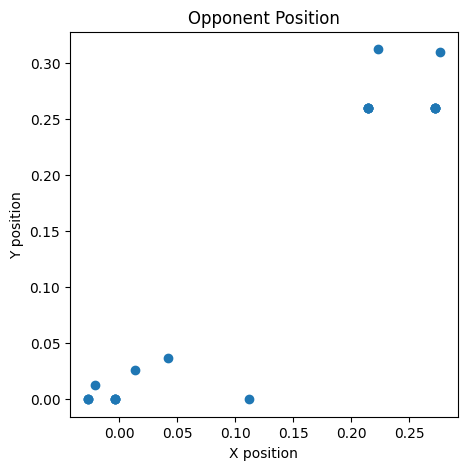

In [ ]:
x_pos = Opponent_Positioning[:,0]
y_pos = Opponent_Positioning[:,1]
plt.figure(figsize = (5,5))
plt.scatter(x_pos, y_pos)
plt.title('Opponent Position')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()


From the plot above, we can see that the opponent position are concentrating at top right and bottom left.

In [ ]:
position = {'left': 0 , 'right': 0, 'top': 0, 'below': 0 }
for sin, cos in Angle_To_Opponent:
  angle_rad = np.arctan2(sin,cos)
  angle_deg = np.degrees(angle_rad)
  if -45 <= angle_deg <=45:
    position['right'] +=1

  elif 45 <= angle_deg <=135:
    position['top']  +=1

  elif -135 <= angle_deg <= -45:
    position['below'] +=1

  else:
    position['left'] +=1


print(position)

{'left': 6, 'right': 5, 'top': 5, 'below': 7}


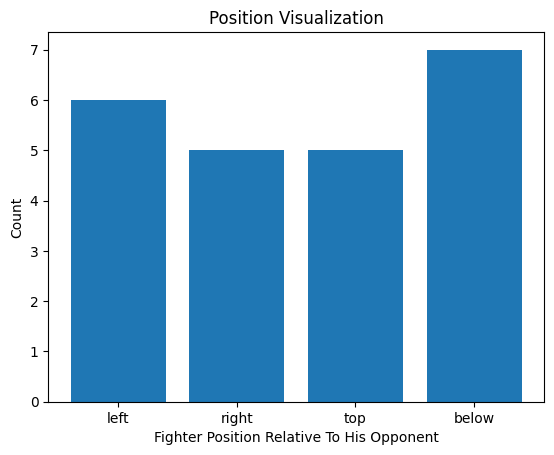

In [ ]:
# plot a barplot to visualize the position distribution
plt.bar(position.keys(), position.values())
plt.xlabel('Fighter Position Relative To His Opponent')
plt.ylabel('Count')
plt.title('Position Visualization')
plt.show()

From the bar plot above, it's evident that the distribution of the fighter's position relative to his opponent is relatively balanced.

In [ ]:
relevant_features_dict = {'Stocks': Stocks,
 'Direction': Direction,
 'Angle_To_Opponent': Angle_To_Opponent,
 'Raycast_Projectile_Distance': Raycast_Projectile_Distance,
 'Raycast_Projectile_OnTarget': Raycast_Projectile_OnTarget,
 'Elemental_Gauge': Elemental_Gauge,
 'Elemental_Advantage': Elemental_Advantage,
 'Distance_To_Opponent': Distance_To_Opponent,
 'Raycast_Platform_Type': Raycast_Platform_Type,
 'Weight_Difference': Weight_Difference,
 'Action_Representation': Action_Representation,
 'Opponent_Positioning': Opponent_Positioning,
 'Raycast_Platform_Distance': Raycast_Platform_Distance,
 'Your_Positioning': Your_Positioning,
 'Percentage': Percentage}

In [ ]:
concat_input_df = pd.DataFrame()
print(f'The length of relevant features should be {len(all_features)}' )
print(type(all_features))
for feature_name, feature_type in relevant_features_dict.items():
    input_df = pd.DataFrame(feature_type, columns=[f'feature{i+1}' for i in range(feature_type.shape[1])])
    concat_input_df = pd.concat([concat_input_df, input_df], axis = 1)

concat_input_df.shape

The length of relevant features should be 23
<class 'numpy.ndarray'>


(23, 99)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, input_data, target_direction, target_other_action):
        self.input_data = torch.Tensor(input_data)
        self.target_direction = torch.LongTensor(target_direction)
        self.target_other_action = torch.LongTensor(target_other_action)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return (
            self.input_data[idx],
            self.target_direction[idx],
            self.target_other_action[idx]
        )


input_data = concat_input_df.values
target_direction = direction_action 
target_other_action = other_action

# Split the data into train and test sets
input_train, input_test, target_direction_train, target_direction_test, target_other_action_train, target_other_action_test = train_test_split(
    input_data, target_direction, target_other_action, test_size=0.2, random_state=42)

# Create MyDataset instances for train and test sets
train_dataset = MyDataset(input_train, target_direction_train, target_other_action_train)
test_dataset = MyDataset(input_test, target_direction_test, target_other_action_test)



# Build the two-headed neural network model

In [ ]:
class TwoHeadedModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_direction, output_size_other):
        super(TwoHeadedModel, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU()
        )
        
        self.head_direction = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size_direction)
        )
        
        self.head_other = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size_other)
        )

    def forward(self, x):
        shared_features = self.shared_layers(x)
        direction_output = self.head_direction(shared_features)
        other_output = self.head_other(shared_features)
        return direction_output, other_output






In [ ]:
# Define the dimensions of the model
input_size = 57  # The number of input features
hidden_size = 36  # The number of hidden units in the model


# Define the output sizes for the new task
new_output_size_direction = 9
new_output_size_other = 6

# Set up the training parameters
batch_size = 8
learning_rate = 0.001
num_epochs = 30

# Load the session 1 model
model_path = '/content/drive/MyDrive/AI_Projects/AI Arena/session1_trained_model.pt'
model = TwoHeadedModel(input_size, hidden_size, new_output_size_direction, new_output_size_other)
model.load_state_dict(torch.load(model_path))

# Specify the number of folds
num_folds = 5
# Create an instance of StratifiedKFold
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kfold.split(input_data, target_direction.argmax(1))):
    # Split the data into train and test sets for the current fold
    input_train, input_test = input_data[train_index], input_data[test_index]
    target_direction_train, target_direction_test = target_direction[train_index], target_direction[test_index]
    target_other_action_train, target_other_action_test = target_other_action[train_index], target_other_action[test_index]

    # Create MyDataset instances for train and test sets
    train_dataset = MyDataset(input_train, target_direction_train, target_other_action_train)
    test_dataset = MyDataset(input_test, target_direction_test, target_other_action_test)

    # Create dataloaders for train and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Freeze the weights of the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the last layers of the model
    model.head_direction[-1] = nn.Linear(hidden_size, new_output_size_direction)
    model.head_other[-1] = nn.Linear(hidden_size, new_output_size_other)

    # Now, only the weights of the new layers will be updated during training

    # Define the loss functions
    criterion_direction = nn.CrossEntropyLoss()
    criterion_other = nn.CrossEntropyLoss()

    # Find the parameters that require gradients
    parameters_to_optimize = filter(lambda p: p.requires_grad, model.parameters())

    # Define the optimizer
    weight_decay = 0.01
    optimizer = optim.Adam(parameters_to_optimize, lr=learning_rate, weight_decay=weight_decay)

    # Train the model on session 2
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets_direction, targets_other in train_loader:
            inputs = inputs[:, :57]
            targets_direction = targets_direction[:, :57]
            targets_other = targets_other[:, :57]

            optimizer.zero_grad()
            outputs_direction, outputs_other = model(inputs)

            # Apply sigmoid activation to outputs_direction
            outputs_direction = torch.sigmoid(outputs_direction)

            # Convert targets_other to class indices
            targets_other_indices = targets_other.argmax(1)

            # Compute the losses
            loss_direction = criterion_direction(outputs_direction, targets_direction.float())
            loss_other = criterion_other(outputs_other, targets_other_indices)

            loss = loss_direction + loss_other

            loss.backward()
            optimizer.step()


            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Fold {fold+1} - Epoch {epoch+1}/{num_epochs} | Training Loss: {epoch_loss:.4f}")




Fold 1 - Epoch 1/30 | Training Loss: 4.0465
Fold 1 - Epoch 2/30 | Training Loss: 4.0188
Fold 1 - Epoch 3/30 | Training Loss: 3.9926
Fold 1 - Epoch 4/30 | Training Loss: 3.9668
Fold 1 - Epoch 5/30 | Training Loss: 3.9409
Fold 1 - Epoch 6/30 | Training Loss: 3.9161
Fold 1 - Epoch 7/30 | Training Loss: 3.8906
Fold 1 - Epoch 8/30 | Training Loss: 3.8662
Fold 1 - Epoch 9/30 | Training Loss: 3.8414
Fold 1 - Epoch 10/30 | Training Loss: 3.8173
Fold 1 - Epoch 11/30 | Training Loss: 3.7942
Fold 1 - Epoch 12/30 | Training Loss: 3.7703
Fold 1 - Epoch 13/30 | Training Loss: 3.7471
Fold 1 - Epoch 14/30 | Training Loss: 3.7249
Fold 1 - Epoch 15/30 | Training Loss: 3.7033
Fold 1 - Epoch 16/30 | Training Loss: 3.6815
Fold 1 - Epoch 17/30 | Training Loss: 3.6600
Fold 1 - Epoch 18/30 | Training Loss: 3.6385
Fold 1 - Epoch 19/30 | Training Loss: 3.6182
Fold 1 - Epoch 20/30 | Training Loss: 3.5971
Fold 1 - Epoch 21/30 | Training Loss: 3.5771
Fold 1 - Epoch 22/30 | Training Loss: 3.5574
Fold 1 - Epoch 23/3

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fold 2 - Epoch 5/30 | Training Loss: 3.8613
Fold 2 - Epoch 6/30 | Training Loss: 3.8373
Fold 2 - Epoch 7/30 | Training Loss: 3.8146
Fold 2 - Epoch 8/30 | Training Loss: 3.7907
Fold 2 - Epoch 9/30 | Training Loss: 3.7687
Fold 2 - Epoch 10/30 | Training Loss: 3.7459
Fold 2 - Epoch 11/30 | Training Loss: 3.7248
Fold 2 - Epoch 12/30 | Training Loss: 3.7030
Fold 2 - Epoch 13/30 | Training Loss: 3.6806
Fold 2 - Epoch 14/30 | Training Loss: 3.6599
Fold 2 - Epoch 15/30 | Training Loss: 3.6382
Fold 2 - Epoch 16/30 | Training Loss: 3.6174
Fold 2 - Epoch 17/30 | Training Loss: 3.5974
Fold 2 - Epoch 18/30 | Training Loss: 3.5753
Fold 2 - Epoch 19/30 | Training Loss: 3.5571
Fold 2 - Epoch 20/30 | Training Loss: 3.5367
Fold 2 - Epoch 21/30 | Training Loss: 3.5180
Fold 2 - Epoch 22/30 | Training Loss: 3.4989
Fold 2 - Epoch 23/30 | Training Loss: 3.4811
Fold 2 - Epoch 24/30 | Training Loss: 3.4634
Fold 2 - Epoch 25/30 | Training Loss: 3.4447
Fold 2 - Epoch 26/30 | Training Loss: 3.4282
Fold 2 - Epoch 

# Evaluation the model accuracy

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score

model.eval()
total_correct_direction = 0
total_correct_other_action = 0
total_samples = 0
predicted_directions = []
predicted_others = []
targets_directions = []
targets_others = []

with torch.no_grad():
    for inputs, targets_direction, targets_other in test_loader:
        inputs = inputs[:, :57]
        targets_direction = targets_direction[:, :57]
        targets_other = targets_other[:, :57]

        outputs_direction, outputs_other = model(inputs)
        
        _, predicted_direction = torch.max(outputs_direction, 1)
        _, predicted_other = torch.max(outputs_other, 1)

        total_correct_direction += (predicted_direction == targets_direction.argmax(dim=1)).sum().item()
        total_correct_other_action += (predicted_other == targets_other.argmax(dim=1)).sum().item()
        
        total_samples += inputs.size(0)
        
        # Collect predictions and targets for later evaluation
        predicted_directions.extend(predicted_direction.cpu().numpy())
        predicted_others.extend(predicted_other.cpu().numpy())
        targets_directions.extend(targets_direction.argmax(dim=1).cpu().numpy())
        targets_others.extend(targets_other.argmax(dim=1).cpu().numpy())

accuracy_direction = total_correct_direction / total_samples * 100
print(f"Accuracy on Session 2 (Directin) Testing Data: {accuracy_direction:.4f}%")


accuracy_direction_other_action = total_correct_other_action / total_samples * 100
print(f"Accuracy on Session 2 (Other Action) Testing Data: {accuracy_direction_other_action:.4f}%")


# Convert the lists to numpy arrays
predicted_directions = np.array(predicted_directions)
predicted_others = np.array(predicted_others)
targets_directions = np.array(targets_directions)
targets_others = np.array(targets_others)

# Calculate F1 score
f1_direction = f1_score(targets_directions, predicted_directions, average='weighted')
f1_other = f1_score(targets_others, predicted_others, average='weighted')
print(f"F1 Score (Direction): {f1_direction:.4f}")
print(f"F1 Score (Other): {f1_other:.4f}")

# Calculate confusion matrix
confusion_matrix_direction = confusion_matrix(targets_directions, predicted_directions)
confusion_matrix_other = confusion_matrix(targets_others, predicted_others)
print("Confusion Matrix (Direction):")
print(confusion_matrix_direction)
print("Confusion Matrix (Other):")
print(confusion_matrix_other)

# Calculate classification report
classification_report_direction = classification_report(targets_directions, predicted_directions)
classification_report_other = classification_report(targets_others, predicted_others)
print("Classification Report (Direction):")
print(classification_report_direction)
print("Classification Report (Other):")
print(classification_report_other)


Accuracy on Session 2 (Directin) Testing Data: 25.0000%
Accuracy on Session 2 (Other Action) Testing Data: 100.0000%
F1 Score (Direction): 0.1000
F1 Score (Other): 1.0000
Confusion Matrix (Direction):
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Confusion Matrix (Other):
[[4]]
Classification Report (Direction):
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.06      0.25      0.10         4
weighted avg       0.06      0.25      0.10         4

Classification Report (Other):
              precision    recall  f1-score   support

           5       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
wei

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model.state_dict(),'session2_trained_model.pt')